# Libraries

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import random
import time
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from scipy.optimize import minimize

import lightgbm as lgb
#import xgboost as xgb
#import catboost as ctb
#from sklearn.linear_model import Ridge

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

# Parameters

In [2]:
target = 'loss'

DEBUG = False

if DEBUG:
    N_ESTIMATORS = 1
    N_SPLITS = 2
    SEED = 17
    CVSEED = 17
    EARLY_STOPPING_ROUNDS = 1
    VERBOSE = 100
    #N_ITERS = 2
else:
    N_SPLITS = 10
    N_ESTIMATORS = 10000
    EARLY_STOPPING_ROUNDS = 200
    VERBOSE = 1000
    SEED = 17
    CVSEED = 17
    #N_ITERS = 10

In [3]:
def set_seed(seed=17):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Datasets

In [4]:
INPUT = Path("../input/tabular-playground-series-aug-2021")

train = pd.read_csv(INPUT / "train.csv")
test = pd.read_csv(INPUT / "test.csv")
submission = pd.read_csv(INPUT / "sample_submission.csv")


# Preprocessing

In [5]:
scale_features = [col for col in test.columns if 'f' in col]

ss = StandardScaler()
train[scale_features] = ss.fit_transform(train[scale_features])
test[scale_features] = ss.transform(test[scale_features])


In [6]:
# Swap noise

# Random
def apply_noise_rn(df, p=.75):
    should_not_swap = np.random.binomial(1, p, df.shape)
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df

# Row-wise
def apply_noise_row(df, p=.75):
    should_not_swap = np.zeros(df.shape)
    for i in range(df.shape[0]):
        for j in np.random.choice(df.shape[1],int(p*df.shape[1]),replace=False):
            should_not_swap[i,j]=1 
    corrupted_df = df.where(should_not_swap == 1, np.random.permutation(df))
    return corrupted_df
    

# LGB

In [7]:
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': N_ESTIMATORS,
    'random_state': SEED,
    'importance_type': 'gain',
    #'device': 'gpu',
    #'gpu_platform_id': 0,
    #'gpu_device_id': 0,
        
    'learning_rate': 0.01376508999204714,
     'subsample': 0.6948557461507425,
     'colsample_bytree': 0.5127040908887421,
     'subsample_freq': 4,
     'reg_lambda': 42.010560753005905,
     'reg_alpha': 27.268524196259943,
     'min_child_weight': 455.1441524357472,
     'min_child_samples': 103
}


In [8]:
lgb_oof = np.zeros(train.shape[0])
lgb_pred = np.zeros(test.shape[0])
lgb_importances = pd.DataFrame()


kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=CVSEED)
seed_list=[SEED, SEED+1, SEED+2]

for fold, (trn_idx, val_idx) in enumerate(kf.split(X=train[scale_features], y=train[target])):
    print(f"===== fold {fold} =====")
    
    X_train, y_train = train[scale_features].iloc[trn_idx], train[target].iloc[trn_idx]
    #X_train = apply_noise_row(X_train)
    
    X_valid, y_valid = train[scale_features].iloc[val_idx], train[target].iloc[val_idx]
    X_test = test[scale_features]
    
    # LGB
    start = time.time()
    
    for inseed in seed_list:
        lgb_params['random_state'] = inseed
    
        pre_model = lgb.LGBMRegressor(**lgb_params)
        pre_model.fit(
            X_train, 
            y_train,
            eval_set=[(X_valid, y_valid)],
            eval_metric='rmse',
            early_stopping_rounds=EARLY_STOPPING_ROUNDS,
            verbose=VERBOSE,
        )

        lgb_params2 = lgb_params.copy()
        lgb_params2['reg_lambda'] *= 0.9
        lgb_params2['reg_alpha'] *= 0.9
        lgb_params2['learning_rate'] *= 0.1
        model = lgb.LGBMRegressor(**lgb_params2)
        model.fit(
                X_train, y_train,
                eval_set=[(X_valid, y_valid)],
                eval_metric='rmse',
                early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                verbose=VERBOSE,
                init_model=pre_model
        )    

        with open(f"lgb_model{fold}.pkl", 'wb') as f:
            pickle.dump(model, f)

        fi_tmp = pd.DataFrame()
        fi_tmp['feature'] = model.feature_name_
        fi_tmp['importance'] = model.feature_importances_
        fi_tmp['fold'] = fold
        fi_tmp['seed'] = inseed
        lgb_importances = lgb_importances.append(fi_tmp)

        lgb_oof[val_idx] += model.predict(X_valid) / len(seed_list)
        lgb_pred += model.predict(X_test) / len(seed_list)
    
    elapsed = time.time() - start
    rmse = mean_squared_error(y_valid, lgb_oof[val_idx], squared=False)
    print(f"fold {fold} - lgb rmse: {rmse:.6f}, elapsed time: {elapsed:.2f}sec\n")

        
print(f"oof lgb_rmse = {mean_squared_error(train[target], lgb_oof, squared=False)}")

np.save("lgb_oof.npy", lgb_oof)
np.save("lgb_pred.npy", lgb_pred)


===== fold 0 =====
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 7.75196
[2000]	valid_0's rmse: 7.74409
Early stopping, best iteration is:
[2624]	valid_0's rmse: 7.74253
Training until validation scores don't improve for 200 rounds
[3000]	valid_0's rmse: 7.74245
[4000]	valid_0's rmse: 7.74219
Early stopping, best iteration is:
[4353]	valid_0's rmse: 7.7421
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 7.75384
[2000]	valid_0's rmse: 7.74609
[3000]	valid_0's rmse: 7.74436
Early stopping, best iteration is:
[2956]	valid_0's rmse: 7.74392
Training until validation scores don't improve for 200 rounds
[3000]	valid_0's rmse: 7.74391
Early stopping, best iteration is:
[3051]	valid_0's rmse: 7.74388
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's rmse: 7.75243
[2000]	valid_0's rmse: 7.74349
Early stopping, best iteration is:
[2307]	valid_0's rmse: 7.74203
Training until validation scores

# OOF predictions

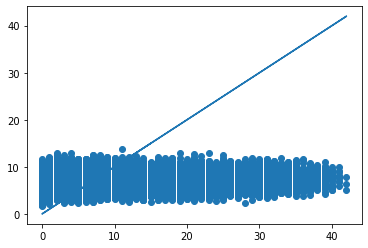

In [9]:
plt.plot(train[target], train[target])
plt.scatter(train[target], lgb_oof)

# Features importances

Text(0.5, 1.0, 'LightGBM feature importances')

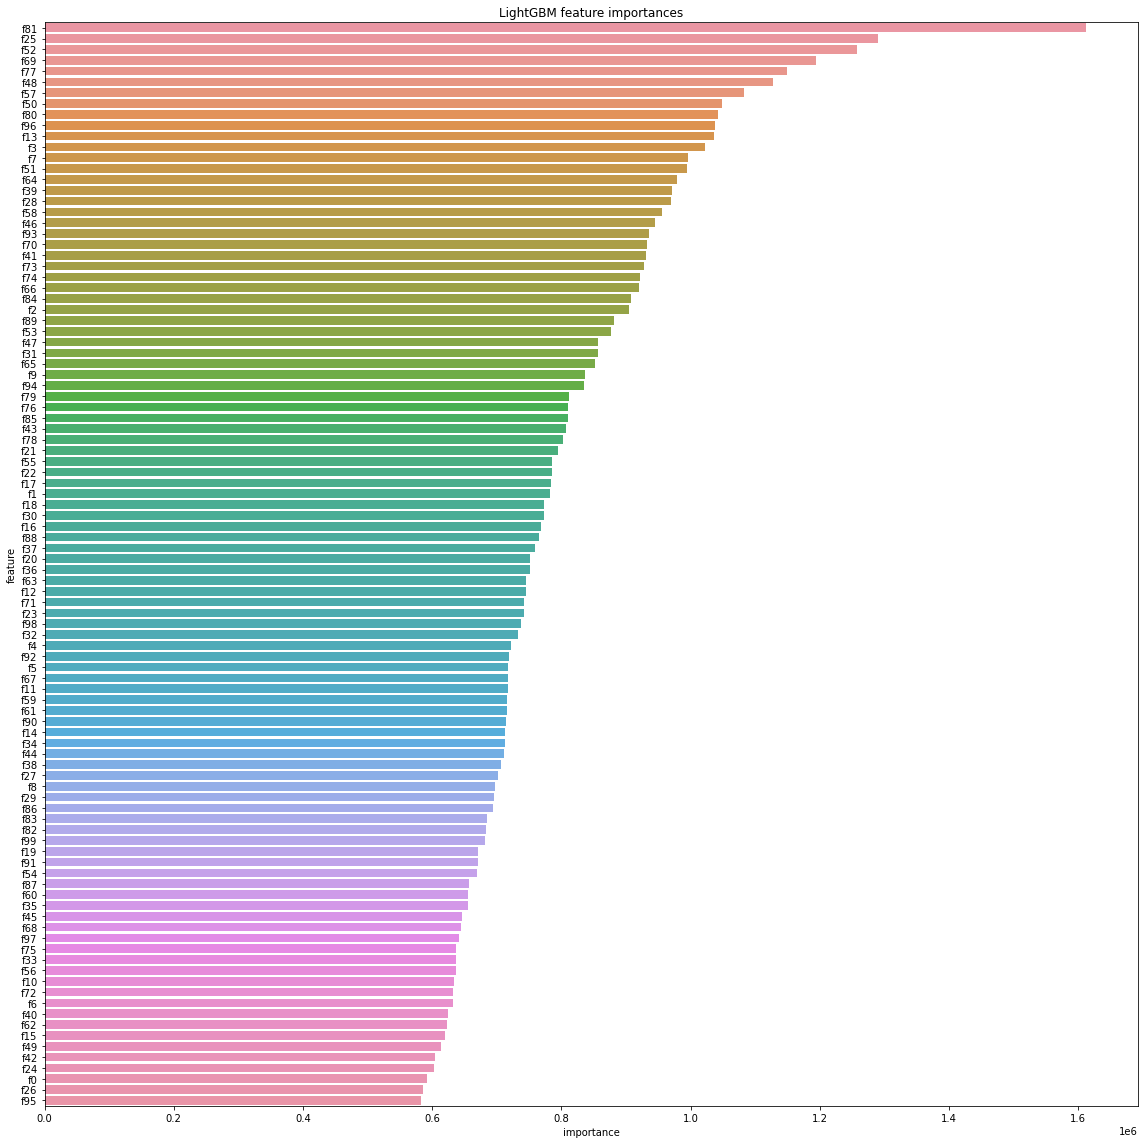

In [10]:
order = list(lgb_importances.groupby('feature').mean().sort_values('importance', ascending=False).index)

fig = plt.figure(figsize=(16, 16), tight_layout=True)
sns.barplot(x="importance", y="feature", data=lgb_importances.groupby('feature').mean().reset_index(), order=order)
plt.title("LightGBM feature importances")

# Submission

In [11]:
submission[target] = lgb_pred
submission.to_csv("submission.csv", index=False)

submission

,id,loss
0,250000,81.207382
1,250001,46.299083
2,250002,85.721196
3,250003,74.964675
4,250004,72.077539
...,...,...
149995,399995,79.065009
149996,399996,75.537435
149997,399997,58.415931
149998,399998,55.910062
